# Volatility Capital: Volatility Cones Trading Strategy
## Constructing Cones from Smoothed Volatility

### 1. Prerequisites and Data

In [120]:
# importing libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import scipy as sp
import seaborn as sns
import matplotlib.cm as cm
from plotnine import *
from plotnine.data import *

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

import pandas_datareader as data
import quandl
import pickle

import functools
import datetime as dt
from datetime import datetime, timedelta
import warnings

import plotly.express as px
import kaleido

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import arch
from sklearn.linear_model import LinearRegression
sns.set()


# configuring
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 65
pd.set_option('use_inf_as_na', True)

sns.set()
color = sns.color_palette()
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

In [130]:
# read data
path = r'/Users/aryamaan/Desktop/QTS/project_data/Smoothie.csv'
data = pd.read_csv(path, header=0, sep=',', quotechar='"')

path2 = r'/Users/aryamaan/Desktop/QTS/project_data/Microchip.gz'
data2 = pd.read_csv(path2, header=0, sep=',', quotechar='"')

In [81]:
# inspect data
data.head()

,date,AMD,SWKS,ADI,INTC,MCHP,MU,NVDA,QCOM,TXN,MPWR,AVGO,NXPI,QRVO
0,2018-01-02,0.537408,0.386165,0.367159,0.389981,0.388720,0.632753,0.503355,0.348037,0.330014,0.463100,0.413170,0.260883,0.440928
1,2018-01-03,0.590844,0.403786,0.366637,0.392424,0.396677,0.669144,0.514094,0.352819,0.326549,0.475314,0.423568,0.262551,0.455234
2,2018-01-04,0.617903,0.408738,0.368557,0.402671,0.398968,0.678362,0.559900,0.352832,0.336955,0.478448,0.426993,0.262274,0.456014
3,2018-01-05,0.639967,0.411790,0.353447,0.407705,0.398847,0.686124,0.560427,0.352428,0.336730,0.477703,0.425671,0.261854,0.447188
4,2018-01-08,0.648767,0.415238,0.335847,0.408136,0.396707,0.677846,0.561136,0.353207,0.337102,0.472257,0.423914,0.261637,0.440501


In [82]:
# inspect data
data.columns

Index(['date', 'AMD', 'SWKS', 'ADI', 'INTC', 'MCHP', 'MU', 'NVDA', 'QCOM',
       'TXN', 'MPWR', 'AVGO', 'NXPI', 'QRVO'],
      dtype='object')

In [83]:
# inspect data
data.shape

(756, 14)

In [39]:
# plotting function
def plot_histogram(df, var, title): 
    plot = (ggplot(data = df, 
               mapping = aes(x = var)) +
             geom_histogram(colour = "black", fill = "white") +
     # 25% quantile
      geom_vline(aes(xintercept=df[var].quantile(.25)),
                color="blue", linetype="dashed", size=1) +
     # median
     geom_vline(aes(xintercept=df[var].quantile(.5)),
                color="blue", linetype="dashed", size=1)+
     # mean
     geom_vline(aes(xintercept=df[var].mean()),
                color="red", linetype="dashed", size=1)+
      # 75% quantile
      geom_vline(aes(xintercept=df[var].quantile(.75)),
                color="blue", linetype="dashed", size=1) +
     theme(element_text(angle = 90, vjust = 0.5, hjust=1)) +
     ggtitle(title)
    )
    
    print(plot)

### 2. Constructing Cones from Smoothed Data

We now have smoothed volatility data from our Statistical Machine Learning Models, as well as the strategy to build cones from fitted realized volatility. We now have all the tools required to visualize where our trading opportunity arises from, by plotting the historical and implied volatilities against cones constructed from historical volatility with a lookback period of 30 days

In [40]:
# convert date to datetime data type
data['date'] = pd.to_datetime(data['date'])

In [41]:
# setting axis as date
data = data.set_index('date')

In [42]:
data.head()

,AMD,SWKS,ADI,INTC,MCHP,MU,NVDA,QCOM,TXN,MPWR,AVGO,NXPI,QRVO
date,,,,,,,,,,,,,
2018-01-02,0.537408,0.386165,0.367159,0.389981,0.388720,0.632753,0.503355,0.348037,0.330014,0.463100,0.413170,0.260883,0.440928
2018-01-03,0.590844,0.403786,0.366637,0.392424,0.396677,0.669144,0.514094,0.352819,0.326549,0.475314,0.423568,0.262551,0.455234
2018-01-04,0.617903,0.408738,0.368557,0.402671,0.398968,0.678362,0.559900,0.352832,0.336955,0.478448,0.426993,0.262274,0.456014
2018-01-05,0.639967,0.411790,0.353447,0.407705,0.398847,0.686124,0.560427,0.352428,0.336730,0.477703,0.425671,0.261854,0.447188
2018-01-08,0.648767,0.415238,0.335847,0.408136,0.396707,0.677846,0.561136,0.353207,0.337102,0.472257,0.423914,0.261637,0.440501


In [73]:
# functionalizing make cones function
def make_cones(vol_data, day_of_interest="2018-11-23", n=30, w="mean"):
    """
    data: df to create cones from
    day of interest: str date to analyze
    n: window for historical volatility
    w: weighting
    """
    ticker = vol_data.columns[0]
    cones = []
    for i in range(1, n):
        df = vol_data.loc[:day_of_interest].copy()
        df = df.reset_index()
        df = df.dropna()
        df = df.sort_values("date")
        df = df.groupby(df.index // 10).filter(lambda x: len(x) == 10).copy()
        df["rank"] = df.groupby(df.index // 10)[ticker].transform(pd.qcut,10, range(1, 11))

        if w == "exp":
            df = pd.DataFrame({"cone" : df.sort_values(["rank", "date"], ascending = False)
                               .groupby("rank")[ticker].apply(lambda x: \
                                                           np.average(x, \
               weights = np.concatenate(([1-.05], [0.05 * (1-.05) ** j for j in range(1, len(x)) ]))))})
            
        elif w == "mean":
            df = pd.DataFrame({"cone" : df.groupby("rank")[ticker].mean()})
            
        df = df.reset_index(drop = False)
        df["days_to_expiry"] = i

        cones.append(df)
    return pd.concat(cones)

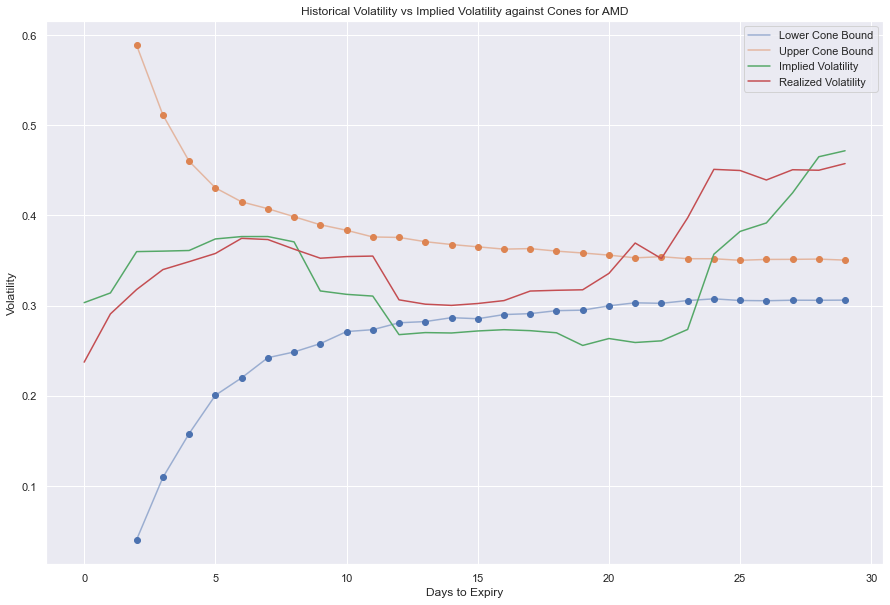

In [151]:
# constructing cones visualization
cones_AMD = make_cones(data[['AMD']])
ggplot(data = cones_AMD, mapping= aes(x = "days_to_expiry", y = "cone", color = "rank")) + \
geom_point() + geom_line()